# Data Collection and Cleaning

This notebook takes data from https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i and prepares it in a way that is easily used for modeling and analysis. 

This dataset includes all valid felony, misdemeanor, and violation crimes reported to the New York City Police Department (NYPD) from 2006 to the end of last year (2019). 

In [3]:
import pandas as pd
from sodapy import Socrata
import datetime
import numpy as np
import re


First we will use the Socrata API to access our data and use it in a pandas dataframe. We choose to limit the results to the most recent 50,000 entires. There are over 7 million entries that could be used and would be interesting to explore with more computing power.

In [13]:
#loading in private token to use on API
with open('token.txt') as f:
    token = f.readlines()
    token = token[0]

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cityofnewyork.us", app_token=token) 

num_of_entries = 50000
# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.cityofnewyork.us,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")


results = client.get("qgea-i56i",limit = num_of_entries)

# Convert to pandas DataFrame
crimes = pd.DataFrame.from_records(results)

First looking at a basic describe on our data frame we can see most of the data comes in as objects. The describe takes a while to run with so many data entires. There are several columns that have missing data but the unique values for each column are pretty low. This will help with our classification problem.

In [8]:
crimes.describe() 

,cmplnt_num,cmplnt_fr_dt,cmplnt_fr_tm,addr_pct_cd,rpt_dt,ky_cd,ofns_desc,pd_cd,pd_desc,crm_atpt_cptd_cd,...,cmplnt_to_tm,loc_of_occur_desc,susp_age_group,susp_race,susp_sex,parks_nm,housing_psa,hadevelopt,transit_district,station_name
count,50000,50000,50000,49992,50000,50000,49998,49892,49892,50000,...,43889,41866,37945,37951,37950,223,3490,2261,1356,1356
unique,50000,672,1429,77,429,56,54,302,270,2,...,1435,5,7,7,3,92,278,222,12,277
top,394506329,2019-11-22T00:00:00.000,12:00:00,75,2019-12-04T00:00:00.000,341,PETIT LARCENY,638.0,"HARASSMENT,SUBD 3,4,5",COMPLETED,...,12:00:00,INSIDE,UNKNOWN,BLACK,M,NA,887.0,CASTLE HILL,2.0,125 STREET
freq,1,1348,1263,1514,1412,10633,10633,5601,5606,49150,...,669,28889,15863,14227,22533,31,57,57,260,52


In [9]:
#looking at the start of the data
crimes.head() 

,cmplnt_num,cmplnt_fr_dt,cmplnt_fr_tm,addr_pct_cd,rpt_dt,ky_cd,ofns_desc,pd_cd,pd_desc,crm_atpt_cptd_cd,...,cmplnt_to_tm,loc_of_occur_desc,susp_age_group,susp_race,susp_sex,parks_nm,housing_psa,hadevelopt,transit_district,station_name
0,394506329,2019-12-31T00:00:00.000,17:30:00,32,2019-12-31T00:00:00.000,118,DANGEROUS WEAPONS,793.0,WEAPONS POSSESSION 3,COMPLETED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,968873685,2019-12-29T00:00:00.000,16:31:00,47,2019-12-29T00:00:00.000,113,FORGERY,729.0,"FORGERY,ETC.,UNCLASSIFIED-FELO",COMPLETED,...,16:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,509837549,2019-12-15T00:00:00.000,18:45:00,109,2019-12-29T00:00:00.000,578,HARRASSMENT 2,638.0,"HARASSMENT,SUBD 3,4,5",COMPLETED,...,NaN,FRONT OF,25-44,UNKNOWN,M,NaN,NaN,NaN,NaN,NaN
3,352454313,2019-12-28T00:00:00.000,01:00:00,47,2019-12-28T00:00:00.000,126,MISCELLANEOUS PENAL LAW,117.0,RECKLESS ENDANGERMENT 1,COMPLETED,...,NaN,REAR OF,18-24,BLACK,M,NaN,NaN,NaN,NaN,NaN
4,248803469,2008-09-05T00:00:00.000,21:41:00,NaN,2008-09-05T00:00:00.000,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,NaN,COMPLETED,...,NaN,OUTSIDE,NaN,NaN,NaN,NA,NA,NaN,NaN,NaN


You can use the original website to see descriptions of the columns but it looks like our data is entered correctly. Notably there is a combination of NaN and 'UNKNOWN' Values that we will have to take care of. We have a total of 40 columns with the following name.

In [10]:
# Looking at all the columns names and how many there are becuase they get cutt off in the notebook
crimes.columns

Index(['cmplnt_num', 'cmplnt_fr_dt', 'cmplnt_fr_tm', 'addr_pct_cd', 'rpt_dt',
       'ky_cd', 'ofns_desc', 'pd_cd', 'pd_desc', 'crm_atpt_cptd_cd',
       'law_cat_cd', 'boro_nm', 'prem_typ_desc', 'juris_desc',
       'jurisdiction_code', 'x_coord_cd', 'y_coord_cd', 'latitude',
       'longitude', 'lat_lon', 'patrol_boro', 'vic_age_group', 'vic_race',
       'vic_sex', ':@computed_region_efsh_h5xi', ':@computed_region_f5dn_yrer',
       ':@computed_region_yeji_bk3q', ':@computed_region_92fq_4b7q',
       ':@computed_region_sbqj_enih', 'cmplnt_to_dt', 'cmplnt_to_tm',
       'loc_of_occur_desc', 'susp_age_group', 'susp_race', 'susp_sex',
       'parks_nm', 'housing_psa', 'hadevelopt', 'transit_district',
       'station_name'],
      dtype='object')

In [11]:
len(crimes.columns)

40

First thing we will do is drop columns that are redundant or would cause problems while making a model. Becuase we are trying to preict offence_level we also have to get rid of any internal coding that means the same thing. (ky_cd is the numeric form of what we are tyring to classify.) Some columns might have too many missing values and we will drop them as well. For example they have the name of a park but most of the crimes don't happen in parks so it would bee too unbalanced for a good model

In [10]:
crimes.isna().sum() #all NaN values (does not include UNKNOWN)

cmplnt_num                         0
cmplnt_fr_dt                       0
cmplnt_fr_tm                       0
addr_pct_cd                        8
rpt_dt                             0
ky_cd                              0
ofns_desc                          3
pd_cd                            107
pd_desc                          107
crm_atpt_cptd_cd                   0
law_cat_cd                         0
boro_nm                          111
prem_typ_desc                    288
juris_desc                         0
jurisdiction_code                107
x_coord_cd                        18
y_coord_cd                        18
latitude                          18
longitude                         18
lat_lon                           18
patrol_boro                      107
vic_age_group                     15
vic_race                           0
vic_sex                            0
:@computed_region_efsh_h5xi      122
:@computed_region_f5dn_yrer       22
:@computed_region_yeji_bk3q       22
:

Based on descriptions and these NaN's we will drop several cols. Short descriptions are listed below in comments of what we dropped

In [14]:
crimes.drop(['ky_cd','ofns_desc','pd_cd', 'pd_desc','loc_of_occur_desc','jurisdiction_code','parks_nm','housing_psa',
            'transit_district','station_name',':@computed_region_efsh_h5xi',':@computed_region_f5dn_yrer',':@computed_region_yeji_bk3q',
           ':@computed_region_92fq_4b7q',':@computed_region_sbqj_enih','lat_lon','x_coord_cd','y_coord_cd','cmplnt_num','patrol_boro',
             'rpt_dt', 'cmplnt_to_dt', 'cmplnt_to_tm'], axis = 1, inplace = True)
#ky_cd-Three digit offense classification code
#ofns_descO-Description of offense corresponding with key code
#pd_cd-Three digit internal classification code
#pd_desc - Description of internal classification corresponding with PD code
#loc_of_occur_desc -Specific location of occurrence in or around the premises; inside, opposite of, front of, rear of-getting rid of this one becuase we have a more useful description
#jurisdiction_code- code of juisdiction found in Juris_desc which had better description and no blank values
#lat_long- lattitude and longitude - have redundant information in other columns
#'x_coord_cd'- have redundant information in other columns
#'y_coord_cd'- have redundant information in other columns
# cmplnt_num - don't need this as the values are indexed
# patrol_boro- same info as boro_nm just broken down a little more, however to keep a better model wanting to do just one
#rpt_dt', 'cmplnt_to_dt', 'cmplnt_to_tm' all have similar date information and we have kept cmplnt_fr_dt','cmplnt_fr_tm' instead
#------too many NAs becuase not all reports happen in pertaining areas------------------
#parks_nm - park number 
#housing_psa - Development Level Code
#transit_district - Transit district in which the offense occurred.
#station_name -Transit station name


#----- random columns that were added---------------------
# :@computed_region_efsh_h5xi      
# :@computed_region_f5dn_yrer       
# :@computed_region_yeji_bk3q       
# :@computed_region_92fq_4b7q       
# :@computed_region_sbqj_enih







We are now left with the following 17 columns. Here are a few summary statistics of what we are left with 

In [20]:
crimes.head()

,cmplnt_fr_dt,cmplnt_fr_tm,addr_pct_cd,crm_atpt_cptd_cd,law_cat_cd,boro_nm,prem_typ_desc,juris_desc,latitude,longitude,vic_age_group,vic_race,vic_sex,susp_age_group,susp_race,susp_sex,hadevelopt
0,2019-12-31T00:00:00.000,17:30:00,32,COMPLETED,FELONY,MANHATTAN,STREET,N.Y. POLICE DEPT,40.82092679700002,-73.94332421899996,UNKNOWN,UNKNOWN,E,NaN,NaN,NaN,NaN
1,2019-12-29T00:00:00.000,16:31:00,47,COMPLETED,FELONY,BRONX,STREET,N.Y. POLICE DEPT,40.885701406000074,-73.86164032499995,UNKNOWN,UNKNOWN,E,NaN,NaN,NaN,NaN
2,2019-12-15T00:00:00.000,18:45:00,109,COMPLETED,VIOLATION,QUEENS,STREET,N.Y. POLICE DEPT,40.74228115600005,-73.81982408,25-44,WHITE HISPANIC,F,25-44,UNKNOWN,M,NaN
3,2019-12-28T00:00:00.000,01:00:00,47,COMPLETED,FELONY,BRONX,STREET,N.Y. POLICE DEPT,40.87531145100007,-73.84754521099995,UNKNOWN,UNKNOWN,E,18-24,BLACK,M,NaN
4,2008-09-05T00:00:00.000,21:41:00,NaN,COMPLETED,FELONY,NaN,NaN,N.Y. POLICE DEPT,40.698827283,-73.938819047,25-44,BLACK,M,NaN,NaN,NaN,NaN


In [21]:
crimes.describe()

,cmplnt_fr_dt,cmplnt_fr_tm,addr_pct_cd,crm_atpt_cptd_cd,law_cat_cd,boro_nm,prem_typ_desc,juris_desc,latitude,longitude,vic_age_group,vic_race,vic_sex,susp_age_group,susp_race,susp_sex,hadevelopt
count,50000,50000,49992,50000,50000,49888,49711,50000,49982,49982,49984,50000,50000,37945,37951,37950,2261
unique,672,1429,77,2,3,5,74,15,23859,23859,9,7,4,7,7,3,222
top,2019-11-22T00:00:00.000,12:00:00,75,COMPLETED,MISDEMEANOR,BROOKLYN,STREET,N.Y. POLICE DEPT,40.75043076800005,-73.98928217599996,25-44,UNKNOWN,F,UNKNOWN,BLACK,M,CASTLE HILL
freq,1348,1263,1514,49150,26395,13880,12982,44607,162,162,18487,13980,20415,15863,14227,22533,57


In [22]:
crimes.isna().sum()

cmplnt_fr_dt            0
cmplnt_fr_tm            0
addr_pct_cd             8
crm_atpt_cptd_cd        0
law_cat_cd              0
boro_nm               112
prem_typ_desc         289
juris_desc              0
latitude               18
longitude              18
vic_age_group          16
vic_race                0
vic_sex                 0
susp_age_group      12055
susp_race           12049
susp_sex            12050
hadevelopt          47739
dtype: int64

Here is each variable with a short description.

|Variable|Description|
|:-|:-|
|cmplnt_fr_dt|Exact date of occurrence for the reported event|
|cmplnt_fr_tm| Exact time of occurrence for the reported event|
|addr_pct_cd |  The precinct in which the incident occurred |                   
|crm_atpt_cptd_cd|Indicator of whether crime was successfully completed or attempted, but failed or was interrupted prematurely |
|law_cat_cd    |     Level of offense: felony, misdemeanor, violation|     
|boro_nm        |       The name of the borough in which the incident occurred|
|prem_typ_desc   |      Specific description of premises; grocery store, residence, street, etc.|
|juris_desc       |       Description of the jurisdiction code|
|latitude    |Midblock Latitude coordinate for Global Coordinate System, WGS 1984, decimal degrees (EPSG 4326)| 
|longitude   |Midblock Longitude coordinate for Global Coordinate System, WGS 1984, decimal degrees (EPSG 4326)
|vic_age_group       |  Victim’s Age Group| 
|vic_race             |   Victim’s Race Description|
|vic_sex        |Victim’s Sex Description (D=Business/Organization, E=PSNY/People of the State of New York, F=Female, M=Male)|
|susp_age_group    |  Suspect’s Age Group |
|susp_race          | Suspect’s Race Description|
|susp_sex            | Suspect’s Sex Description |
|hadevelopt        |Name of NYCHA housing development of occurrence, if applicable|


We have decided to keep hadevelopt in our data and change it to a boolean variable. If it occured in a housing development it will be a 1 and a 0 if not. We thingk this might be a good indicator of the offense level.

In [23]:
# Make development column a true (1) or false(0)
crimes['hadevelopt'] = crimes['hadevelopt'].fillna(0)
for i in range(0,num_of_entries):
    if crimes['hadevelopt'][i] != 0:
        crimes['hadevelopt'][i] = 1

From the cmplnt_fr_dt we are changing it so that the month is left as a number from 1-12 and the time of day is split into a quarter system of morning, afternoon, evening, and night.

In [24]:
# change date column to month numbers to help with time of year
# we can change this to quarter of the year if that makes it easier
crimes['cmplnt_fr_dt'] = crimes.cmplnt_fr_dt.replace({'T00:00:00.000':''}, regex=True)
for x in range(0,num_of_entries):
    temp = crimes['cmplnt_fr_dt'][x]
    temp = temp.split('-')[1]
    crimes['cmplnt_fr_dt'][x] = temp

In [25]:
# break up the time into groups
# morning: 5 AM - Noon = 1
# afternoon: Noon - 6 PM = 2
# evening: 6 PM - 10 PM = 3
# night: 10 PM - 5 AM = 4
for z in range(0,num_of_entries):
    time = crimes['cmplnt_fr_tm'][z]
    time = int(time.split(':')[0])
    if 5 <= time < 12:
        crimes['cmplnt_fr_tm'][z] = 1
    elif 12 <= time < 18:
        crimes['cmplnt_fr_tm'][z] = 2
    elif 18 <= time < 22:
        crimes['cmplnt_fr_tm'][z] = 3
    else:
        crimes['cmplnt_fr_tm'][z] = 4

We now will change all 'UNKNOWN' and 'U' entris in our colums to NaN so it is more uniform and easier to deal with

In [27]:
# change all unknown to NaN values
crimes.replace(r"UNKNOWN", np.nan, inplace=True) #change UNKNOWN to NaN
crimes['susp_sex'].replace(r"U", np.nan, inplace=True) #change U to NaN

Looking at the age groups we notices there were a few negative numbers or ages that were too high. We removed these to NaN values.

In [28]:
crimes.susp_age_group.value_counts()

25-44    12120
45-64     4411
18-24     3909
<18       1210
65+        431
-965         1
Name: susp_age_group, dtype: int64

In [29]:
# change age outliers to unknowns (a couple of super large and negative numbers)
for i in range(0, 50000):
    num = crimes['vic_age_group'][i]
    if num == '943':
        crimes['vic_age_group'][i] = np.nan
    elif num == '-954':
        crimes['vic_age_group'][i] = np.nan
    elif num == '-56':
        crimes['vic_age_group'][i] = np.nan
        
for i in range(0, 50000):
    num = crimes['susp_age_group'][i]
    if num == '-965':
        crimes['susp_age_group'][i] = np.nan

/var/folders/vt/6r5q3_2925x9zfpjzspnm9pw0000gn/T/ipykernel_77819/1881970159.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crimes['vic_age_group'][i] = np.nan
/var/folders/vt/6r5q3_2925x9zfpjzspnm9pw0000gn/T/ipykernel_77819/1881970159.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crimes['vic_age_group'][i] = np.nan
/var/folders/vt/6r5q3_2925x9zfpjzspnm9pw0000gn/T/ipykernel_77819/1881970159.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

We have now renamed the columns so it's something easier to remeber. 

In [30]:
# rename columns to something we can easily remember
crimes.columns = ['month', 'time_of_day', 'precinct', 'crime_completed', 'offense_level', 'borough_name', 'premises',
                  'jurisdiction_code', 'latitude', 'longitude', 'victim_age_group', 'victim_race', 'victim_sex',
                  'suspect_age_group', 'suspect_race', 'suspect_sex', 'city_housing']

Our clean data now looks like this

In [32]:
crimes

,month,time_of_day,precinct,crime_completed,offense_level,borough_name,premises,jurisdiction_code,latitude,longitude,victim_age_group,victim_race,victim_sex,suspect_age_group,suspect_race,suspect_sex,city_housing
0,12,2,32,COMPLETED,FELONY,MANHATTAN,STREET,N.Y. POLICE DEPT,40.82092679700002,-73.94332421899996,NaN,NaN,E,NaN,NaN,NaN,0
1,12,2,47,COMPLETED,FELONY,BRONX,STREET,N.Y. POLICE DEPT,40.885701406000074,-73.86164032499995,NaN,NaN,E,NaN,NaN,NaN,0
2,12,3,109,COMPLETED,VIOLATION,QUEENS,STREET,N.Y. POLICE DEPT,40.74228115600005,-73.81982408,25-44,WHITE HISPANIC,F,25-44,NaN,M,0
3,12,4,47,COMPLETED,FELONY,BRONX,STREET,N.Y. POLICE DEPT,40.87531145100007,-73.84754521099995,NaN,NaN,E,18-24,BLACK,M,0
4,09,3,NaN,COMPLETED,FELONY,NaN,NaN,N.Y. POLICE DEPT,40.698827283,-73.938819047,25-44,BLACK,M,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,11,4,42,COMPLETED,MISDEMEANOR,BRONX,RESIDENCE - APT. HOUSE,N.Y. POLICE DEPT,40.834571796000034,-73.88831133599997,45-64,WHITE HISPANIC,F,NaN,BLACK,M,0
49996,11,2,25,COMPLETED,MISDEMEANOR,MANHATTAN,CHURCH,N.Y. POLICE DEPT,40.79700470100005,-73.93468731899996,65+,WHITE HISPANIC,F,NaN,NaN,NaN,0
49997,11,4,46,COMPLETED,VIOLATION,BRONX,RESIDENCE - APT. HOUSE,N.Y. POLICE DEPT,40.85474299400005,-73.91437303499998,25-44,BLACK,F,18-24,BLACK,F,0
49998,11,1,88,COMPLETED,FELONY,BROOKLYN,DOCTOR/DENTIST OFFICE,N.Y. POLICE DEPT,40.69394323400008,-73.96165390999995,45-64,ASIAN / PACIFIC ISLANDER,M,NaN,BLACK,F,0


In [33]:
crimes.to_csv("clean_crime.csv") #exporting cleaned dataset

The next step is to do Exploratory data analysis now that we have a cleaned dataset. We have put it in a seperate notebook to help the flow. See  ExploratoryDataAnalysis.ipynb for this next step

In [23]:
import numpy as np

from sklearn.base import TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [24]:
crimes = pd.read_csv('clean_crime.csv')

In [25]:
crimes['month'] = crimes['month'].astype(str)
crimes['time_of_day'] = crimes['time_of_day'].astype(str)
crimes['precinct'] = crimes['precinct'].astype(str)
crimes['city_housing'] = crimes['city_housing'].astype(str)



In [26]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

crimes = DataFrameImputer().fit_transform(crimes)

In [27]:
X = crimes[['month', 'time_of_day', 'precinct', 'crime_completed', 'borough_name', 'premises',
                  'jurisdiction_code', 'latitude', 'longitude', 'victim_age_group', 'victim_race', 'victim_sex',
                  'suspect_age_group', 'suspect_race', 'suspect_sex', 'city_housing']]

In [28]:
categorical_feature_mask = X.dtypes==object
numerical_features_mask = X.dtypes!=object
categorical_cols = X.columns[categorical_feature_mask].tolist()
numerical_cols = X.columns[numerical_features_mask].tolist()
X_cat = X[categorical_cols]
X_cat = pd.get_dummies(X_cat)
X = X_cat.join(X[numerical_cols])

In [29]:
X = pd.get_dummies(X)
y = crimes['offense_level']

In [30]:
y.value_counts()

MISDEMEANOR    26395
FELONY         15634
VIOLATION       7971
Name: offense_level, dtype: int64

In [31]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=426, stratify=y, test_size=.2)

In [33]:
bag = BaggingClassifier(n_estimators=100, n_jobs=-1)
bag.fit(X_train,y_train)
bag_pred = bag.predict(X_test)

In [34]:
print(metrics.confusion_matrix(y_test, bag_pred))
print(metrics.classification_report(y_test, bag_pred))

[[1172 1770  185]
 [1003 3913  363]
 [ 226  946  422]]
              precision    recall  f1-score   support

      FELONY       0.49      0.37      0.42      3127
 MISDEMEANOR       0.59      0.74      0.66      5279
   VIOLATION       0.44      0.26      0.33      1594

    accuracy                           0.55     10000
   macro avg       0.50      0.46      0.47     10000
weighted avg       0.53      0.55      0.53     10000



In [35]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=3)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

In [36]:
print(metrics.confusion_matrix(y_test, rf_pred))
print(metrics.classification_report(y_test, rf_pred))

[[   2 3125    0]
 [   0 5279    0]
 [   0 1594    0]]
              precision    recall  f1-score   support

      FELONY       1.00      0.00      0.00      3127
 MISDEMEANOR       0.53      1.00      0.69      5279
   VIOLATION       0.00      0.00      0.00      1594

    accuracy                           0.53     10000
   macro avg       0.51      0.33      0.23     10000
weighted avg       0.59      0.53      0.37     10000



C:\Users\bentlia0\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bentlia0\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bentlia0\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


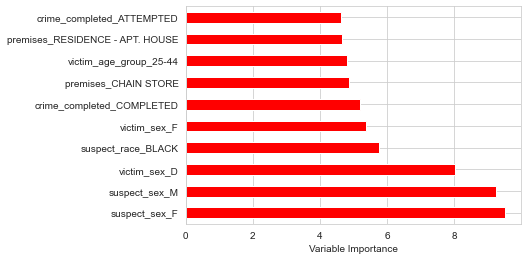

In [37]:
Importance = pd.DataFrame({'Importance':rf.feature_importances_*100}, index=X_train.columns)
Importance = Importance.iloc[rf.feature_importances_ > 0,:]
Importance = Importance.sort_values('Importance', axis=0, ascending=True)
Importance.sort_values('Importance', axis=0, ascending=False).head(10).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

In [38]:
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=.1)
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)

In [39]:
print(metrics.confusion_matrix(y_test, gb_pred))
print(metrics.classification_report(y_test, gb_pred))

[[ 448 2593   86]
 [ 232 4885  162]
 [  41 1291  262]]
              precision    recall  f1-score   support

      FELONY       0.62      0.14      0.23      3127
 MISDEMEANOR       0.56      0.93      0.70      5279
   VIOLATION       0.51      0.16      0.25      1594

    accuracy                           0.56     10000
   macro avg       0.56      0.41      0.39     10000
weighted avg       0.57      0.56      0.48     10000



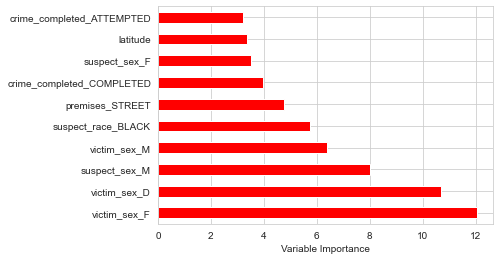

In [40]:
Importance = pd.DataFrame({'Importance':gb.feature_importances_*100}, index=X_train.columns)
Importance = Importance.iloc[gb.feature_importances_ > 0,:]
Importance = Importance.sort_values('Importance', axis=0, ascending=True)
Importance.sort_values('Importance', axis=0, ascending=False).head(10).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None